# TUTORIAL 2 - LEAKY INTEGRATE-AND-FIRE NEURON

In [1]:
# imports:

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

# 1. THE SPECTRUM OF NEURON MODELS

A large variety of neuron models exist, ranging from biophysically accurate models to the extremely simple artificial neuron that are used in artificial neural networks such as the perceptron. 

**Hodgkin-Huxley Neuron Models** - biophysically accurate models that describe the dynamics of ion channels in the neuron membrane with high accuracy. However, their complexity makes them difficult to use.

**Artificial Neuron Model** - On the other end of the spectrum, we have the artificial neuron model. The inputs are multiplied by their corresonding weights, and passed through an activation function. This type of model is the one used in common artificial neural networks.

**Leaky Integrate-and-Fire Neuron Models** - Somewhere in between these two extremes, we find the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, but rather than passing it directly to the activation function, it integrates the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a thresholds, the neuron emits a voltage spike. Information is not stored within the spike, but rather in the timing (or frequency) of the spikes.

There are different versions of the LIF model, each with its own dymaics and use cases. Currently these are implemented in `snnTorch`:

* Lapicque's RC model: `snntorch,Lapicque`
* 1st-order model: `snntorch.Leaky`
* Synaptic Conductance-based neuron model: `snntorch.Synaptic`
* Recurrent 1st-order model: `snntorch.RLeaky`
* Recurrent Synaptic Conductance-based neuron model: `snntorch.RSynaptic`
* Alpha neuron model: `snntorch.Alpha`

## Forward Euler Method to Solving the LIF Model
The membrane potential of the LIF model is modeled as an RC circuit, where the membrane potential $U(t)$ is the voltage across the capacitor, and the input current is: 
$$
I_{in}(t)=I_R(t)+I_C(t)
$$

The LIF model can be described by the following differential equation:
$$
{\tau}\frac{dU(t)}{dt} = -U(t) + RI_{in}(t)
$$

The analytical solution to this equation is:
$$
U(t) =RI_{in}(t) + \left(U(0) - RI_{in}(t)\right) e^{-\frac{t}{\tau}}
$$

Where $R$ is the resistance, $C$ is the capacitance, and $\tau = RC$ is the time constant of the circuit.

However, the analytical solution is not practical for numerical simulations and neural networks. Instead, we can use the Forward Euler method to approximate the solution of the ordinary differential equation (ODE). The Forward Euler method is a numerical method for solving ODEs, which approximates the solution at discrete time steps.
First, let's descrive the dirivative of the membrane potential in the equation, without taking the limit $\Delta t \rightarrow 0$:
$$
\tau\frac{dU(t)}{dt} = \tau\frac{U(t+\Delta t) - U(t)}{\Delta t} = -U(t) + RI_{in}(t)
$$

If $\Delta t$ is small enough, this gives us a good enough approximation of continuous-time integration. Rearranging the equation, we get:
$$
U(t+\Delta t) = U(t) + \frac{\Delta t}{\tau}\left(-U(t) + RI_{in}(t)\right)
$$

This following function represents this equation in code:

In [2]:
def leaky_integrate_and_fire(U, time_step=1e-3, I=0, R=50e6, C=100e-12):
    """
    Leaky Integrate-and-Fire neuron model.
    
    Args:
        U (torch.Tensor): Membrane potential.
        time_step (float): Time step for simulation.
        I (float): Input current.
        R (float): Resistance.
        C (float): Capacitance.
    
    Returns:
        torch.Tensor: Updated membrane potential.
    """
    tau = R * C  # Time constant
    U = U + time_step/tau *(-U + R*I)
    return U

Now, loop through the time steps and measure the membrane potential. 
Lets initialize the membrane potential to $U(0) = 0.9V$, and assume there is no input current $I_{in}(t) = 0$

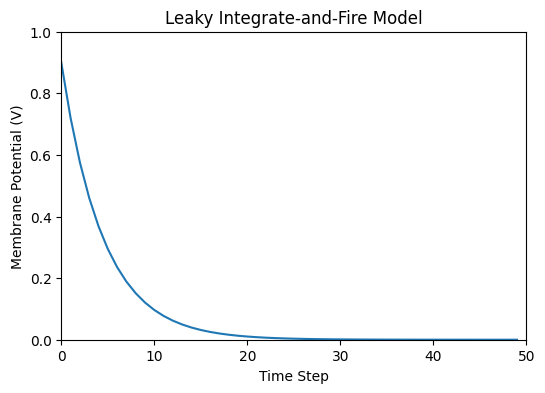

In [3]:
U = 0.9
I_in = 0.0
num_steps = 50
U_trace = []

for step in range(num_steps):
    U_trace.append(U)
    U = leaky_integrate_and_fire(U) # Solve for next time step

# Plot the membrane potential over time
plt.figure(figsize=(6, 4))
plt.plot(np.arange(num_steps), U_trace)
plt.xlim(0, num_steps)
plt.ylim(0, 1.0)
plt.title('Leaky Integrate-and-Fire Model')
plt.xlabel('Time Step')
plt.ylabel('Membrane Potential (V)')
plt.show()

## LAPICQUE'S NIF NEURON MODEL
This similarity between nerve membranes and RC circuits was observed by Louis Lapicque in 1907. He stimulated the nerve fiber of a frog with a brief electrical pulse, and found that neuron membranes could be approximated as a capacitor with a leakage. We pay homage to his findings by naming the basic LIF neuron model in snnTorch after him.

Most of the concepts in Lapicque’s model carry forward to other LIF neuron models. Now it’s time to simulate this neuron using snnTorch. We will repeat the same calculation as above, but using the `Lapicque` class from `snnTorch`. 

In [4]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate-and-fire neuron model, tau = 5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

# Initialize the membrane potential
Umem = torch.ones(1) * 0.9  # Initial membrane potential
cur_in = torch.zeros(num_steps, 1)  # Input current=0
spk_out = torch.zeros(1) # initialize output spikes

# To analyze the evolution of `Umem`` over time, create a list `mem_rec`` to record these values at every time step
Umem_rec = [Umem]


Now it’s time to run a simulation! At each time step, `Umem` is updated and stored in `Umem_rec`

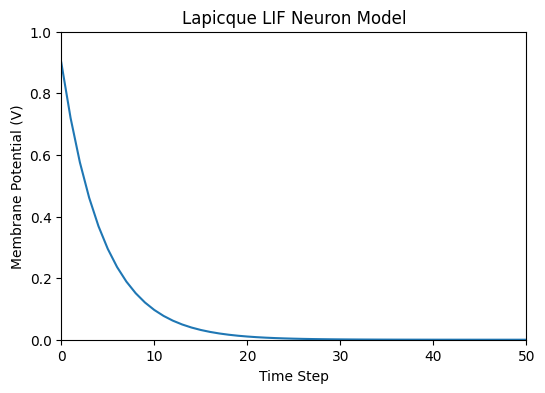

In [5]:
for step in range(num_steps):
    spk_out, Umem = lif1(cur_in[step], Umem)

    # store the membrane potential at each time step
    Umem_rec.append(Umem)

# Convert the list of tensors to one tensor
Umem_rec = torch.stack(Umem_rec)

# Plot the membrane potential over time
plt.figure(figsize=(6,4))
plt.plot(np.arange(num_steps + 1), Umem_rec.numpy())
plt.xlim(0, num_steps)
plt.ylim(0, 1.0)
plt.title('Lapicque LIF Neuron Model')
plt.xlabel('Time Step')
plt.ylabel('Membrane Potential (V)')
plt.show()


The membrane potential decays over time in the absence of any input stimuli.

## 3.2 LAPICQUE: STEP INPUT

Now, let's apply a step current input $I_{in}(t)$ that switches on at $t=0$. Lets also assume that the initial membrane potential is $U(t=0) = 0V$.
The analytical solution to this equation is:
$$
U=I_{in}R\left(1-e^{-\frac{t}{\tau}}\right)
$$
Based on this explicit time-depent form, we expect $U$ to increase over time, and approach the value $I_{in}R$ as $t \rightarrow \infty$.
Lets visulaize this by triggering a current step of $I_{in}(t\geq 10ms)=100mA$

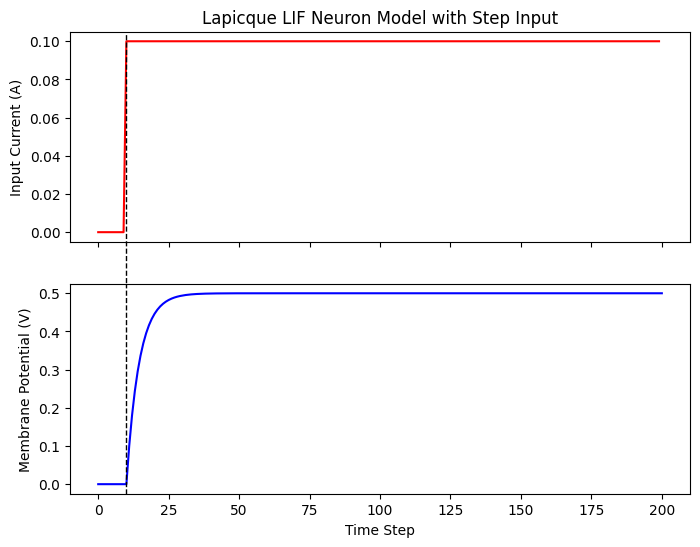

In [6]:
time_step = 1e-3
Istep = 100e-3  # Step current input
curr_in = torch.zeros(200,1)
curr_in[10:] = Istep  # Step current input

# Initialize the membrane potential
Umem = torch.zeros(1)  # Initial membrane potential at t=0 is 0V
spk_out = torch.zeros(1)  # Initialize output spikes
Umem_rec = [Umem]  # To record the membrane potential at each time step

num_steps = len(curr_in)
# pass the membrane potential and input current at every time step
for step in range(num_steps):
    spk_out, Umem = lif1(curr_in[step], Umem)

    # store the membrane potential at each time step
    Umem_rec.append(Umem)

# Convert the list of tensors to one tensor
Umem_rec = torch.stack(Umem_rec)

# Plot the membrane potential over time
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(np.arange(num_steps), curr_in.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_title('Lapicque LIF Neuron Model with Step Input')

axs[1].plot(np.arange(num_steps + 1), Umem_rec.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')

axs[0].axvline(x=10, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=10, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)


## 3.3 LAPICQUE: PULSE INPUT
Now, let's apply a step input, and clip it at $t=30msec$

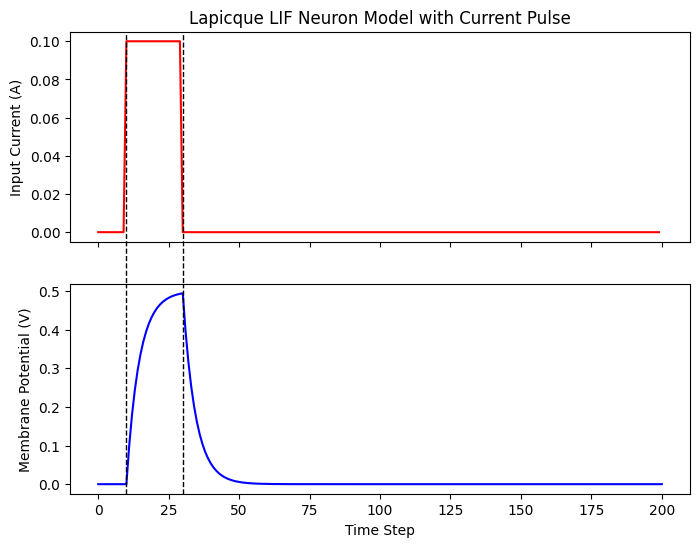

In [7]:
# Initialize the current pulse, membrane potential, and spike output
curr_in1 = torch.zeros(200, 1)
curr_in1[10:30] = Istep  # Current pulse from t=10

Umem1 = torch.zeros(1)  # Initial membrane potential at t=0 is 0V
spk_out1 = torch.zeros(1)  # Initialize output spikes
Umem_rec1 = [Umem1]  # To record the membrane potential at each time step

# neuron simulation
for step in range(len(curr_in1)):
    spk_out1, Umem1 = lif1(curr_in1[step], Umem1)

    # store the membrane potential at each time step
    Umem_rec1.append(Umem1)

# Convert the list of tensors to one tensor
Umem_rec1 = torch.stack(Umem_rec1)

# Plot the membrane potential over time
fig, axs = plt.subplots(2, 1, figsize=(8, 6),
                          sharex=True)
axs[0].plot(np.arange(len(curr_in1)), curr_in1.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_title('Lapicque LIF Neuron Model with Current Pulse')
axs[1].plot(np.arange(len(curr_in1) + 1), Umem_rec1.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')

axs[0].axvline(x=10, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=10, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[0].axvline(x=30, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=30, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

Notice that $U_{mem}$ rises just as it did to the step input, but no it also decays with a time constant $\tau$ after the input is removed. 

Now, lets stimulate the same amount of charge, but in half the time. This means the input current must be increased a little, and the time window must be shorter.

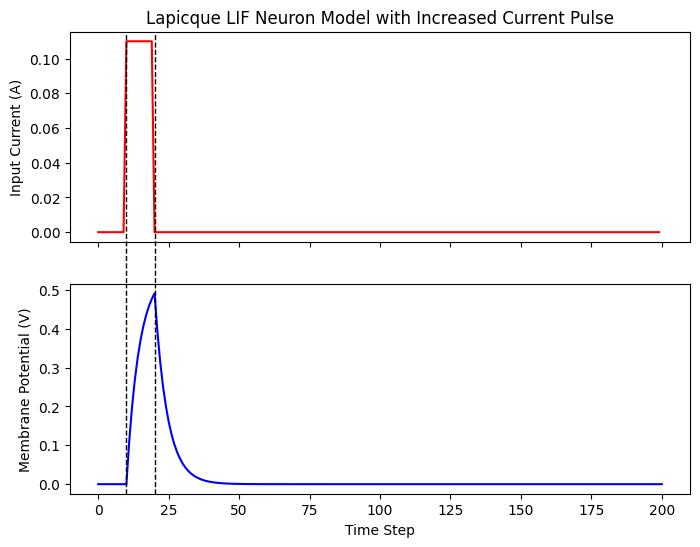

In [8]:
# increase the amplitude of the current pulse; half the time
curr_in2 = torch.zeros(200, 1)
curr_in2[10:20] = 1.1 * Istep  # Current pulse from t=10
Umem2 = torch.zeros(1)  # Initial membrane potential at t=0 is 0V
spk_out2 = torch.zeros(1)  # Initialize output spikes
Umem_rec2 = [Umem2]  # To record the membrane potential at each time step

# neuron simulation
for step in range(len(curr_in2)):
    spk_out2, Umem2 = lif1(curr_in2[step], Umem2)

    # store the membrane potential at each time step
    Umem_rec2.append(Umem2) 

# Convert the list of tensors to one tensor
Umem_rec2 = torch.stack(Umem_rec2)

# Plot the membrane potential over time
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in2)), curr_in2.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_title('Lapicque LIF Neuron Model with Increased Current Pulse')
axs[1].plot(np.arange(len(curr_in2) + 1), Umem_rec2.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')  

axs[0].axvline(x=10, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=10, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[0].axvline(x=20, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=20, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

Lets repeat the same experiment again, but with an even faster input pulse and higher amplitude. 

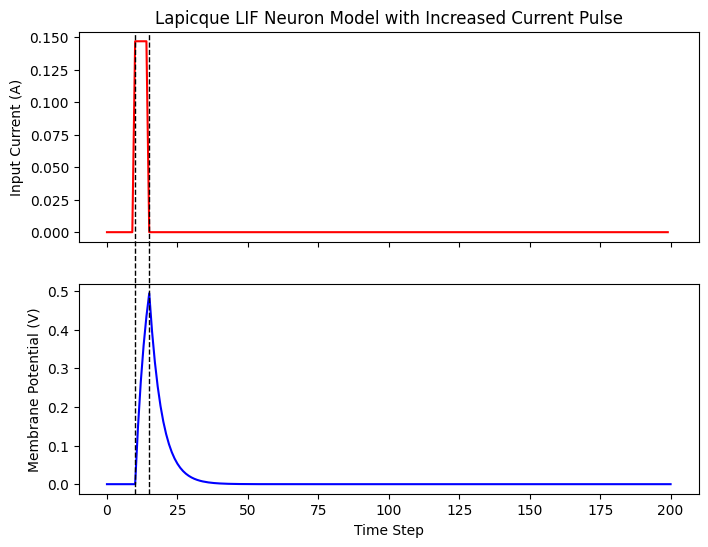

In [9]:
# Increase amplitude of current pulse and quarter the time
curr_in3 = torch.zeros(200, 1)
curr_in3[10:15] = 1.47 * Istep  # Current pulse from t=10
Umem3 = torch.zeros(1)  # Initial membrane potential at t=0 is 0V
spk_out3 = torch.zeros(1)  # Initialize output spikes
Umem_rec3 = [Umem3]  # To record the membrane potential at each time step

# neuron simulation
for step in range(len(curr_in3)):
    spk_out3, Umem3 = lif1(curr_in3[step], Umem3)

    # store the membrane potential at each time step
    Umem_rec3.append(Umem3) 

# Convert the list of tensors to one tensor
Umem_rec3 = torch.stack(Umem_rec3)

# Plot the membrane potential over time
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in3)), curr_in3.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_title('Lapicque LIF Neuron Model with Increased Current Pulse')
axs[1].plot(np.arange(len(curr_in3) + 1), Umem_rec3.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')  

axs[0].axvline(x=10, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=10, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[0].axvline(x=15, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=15, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

Now lets compare all three experiments on the same plot.

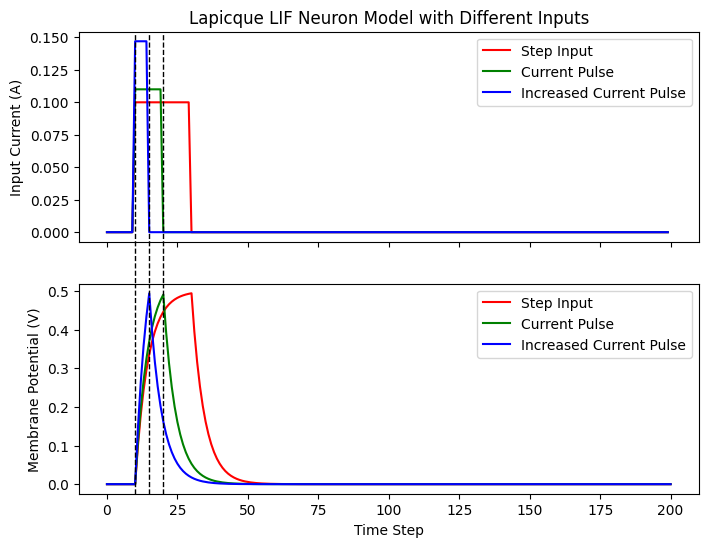

In [10]:
# Plot all three experiments on the same plot
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in1)), curr_in1.numpy(), color='r', label='Step Input')
axs[0].plot(np.arange(len(curr_in2)), curr_in2.numpy(), color='g', label='Current Pulse')
axs[0].plot(np.arange(len(curr_in3)), curr_in3.numpy(), color='b', label='Increased Current Pulse')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_title('Lapicque LIF Neuron Model with Different Inputs')
axs[0].legend()

axs[1].plot(np.arange(len(Umem_rec1)), Umem_rec1.numpy(), color='r', label='Step Input')
axs[1].plot(np.arange(len(Umem_rec2)), Umem_rec2.numpy(), color='g', label='Current Pulse')
axs[1].plot(np.arange(len(Umem_rec3)), Umem_rec3.numpy(), color='b', label='Increased Current Pulse')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')
axs[1].legend() 

axs[0].axvline(x=10, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=10, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[0].axvline(x=20, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=20, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[0].axvline(x=15, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=15, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

plt.show()



As the input current pulse ampitute increases, the rise time of the membrane potential speeds up. In the limit of the input current pulse width becoming infinitesimally small $T_W \rightarrow 0$, and an infinitely large input current $I_{in} \rightarrow \infty$, the membrane potential will jump straight up in virtually zero rise time (delta function response).

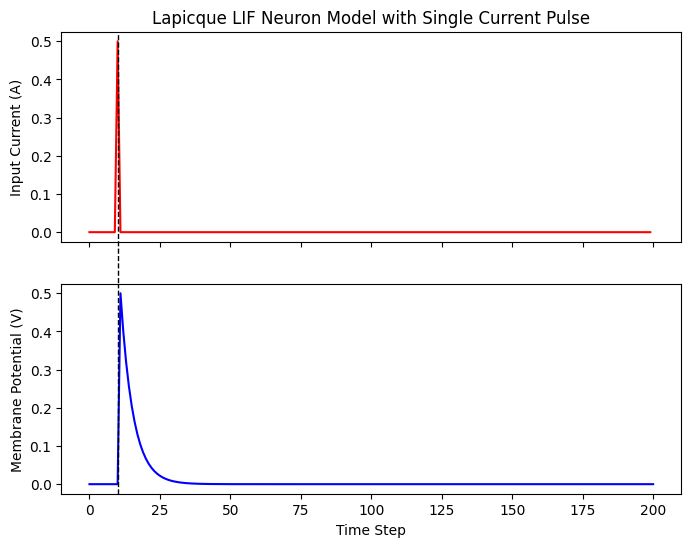

In [11]:
curr_in4 = torch.zeros(200, 1)
curr_in4[10]=0.5  # Current pulse from t=10
Umem4 = torch.zeros(1)  # Initial membrane potential at t=0 is 0V
spk_out4 = torch.zeros(1)  # Initialize output spikes
Umem_rec4 = [Umem4]  # To record the membrane potential at each time step

# neuron simulation
for step in range(len(curr_in4)):
    spk_out4, Umem4 = lif1(curr_in4[step], Umem4)

    # store the membrane potential at each time step
    Umem_rec4.append(Umem4)

# Convert the list of tensors to one tensor
Umem_rec4 = torch.stack(Umem_rec4)

# Plot the membrane potential over time
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in4)), curr_in4.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_title('Lapicque LIF Neuron Model with Single Current Pulse')
axs[1].plot(np.arange(len(curr_in4) + 1), Umem_rec4.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')

axs[0].axvline(x=10, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=10, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

plt.show()

## 3.4 LAPICQUE: FIRING
So far, we have only simulated the membrane potential of the neuron. However, the LIF model is a spiking neuron model, which means it emits spikes when the membrane potential exceeds a threshold.

Lets modify `leaky_integrate_neuron` function from before to add a spike response.

In [12]:
def leaky_intergrate_and_fire(U, time_step=1e-3, I=0, R=5.1, C=5e-3, threshold=1.0):
    """
    Leaky Integrate-and-Fire neuron model with spike response.
    
    Args:
        U (torch.Tensor): Membrane potential.
        time_step (float): Time step for simulation.
        I (float): Input current.
        R (float): Resistance.
        C (float): Capacitance.
        threshold (float): Spike threshold.
    
    Returns:
        torch.Tensor: Updated membrane potential and spike output.
    """
    tau = R * C  # Time constant
    spk = (U > threshold)
    U = U + time_step/tau *(-U + R*I)
    
    return U, spk

As seen in the figure above, the neuron emits spikes out of control. This is becaus we did not implement any reset mechanism. In reality, each time a neuron fires, the membrance potential resets back to its resting potential.

In [13]:
def leaky_intergrate_and_fire(U, time_step=1e-3, I=0, R=5.1, C=5e-3, threshold=1.0):
    """
    Leaky Integrate-and-Fire neuron model with spike response.
    
    Args:
        U (torch.Tensor): Membrane potential.
        time_step (float): Time step for simulation.
        I (float): Input current.
        R (float): Resistance.
        C (float): Capacitance.
        threshold (float): Spike threshold.
    
    Returns:
        torch.Tensor: Updated membrane potential and spike output.
    """
    tau = R * C  # Time constant
    spk = (U > threshold)
    U = U + time_step/tau *(-U + R*I) - spk*threshold # Every time a neuron spikes, reset the membrane potential
    
    return U, spk

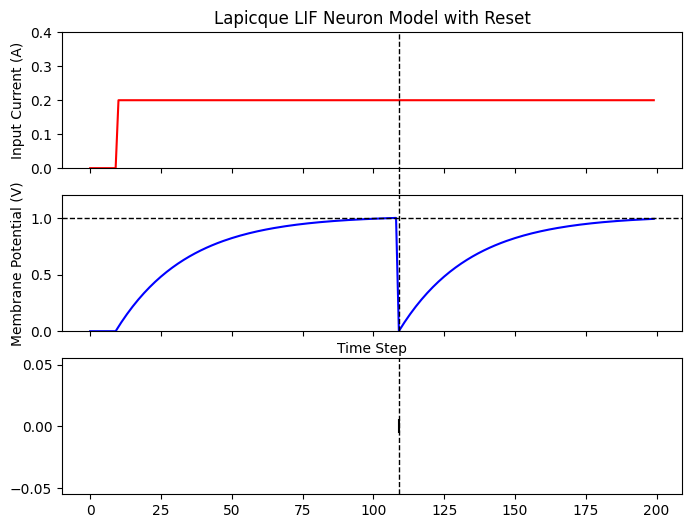

In [14]:
# Small step current input
curr_in = torch.zeros(200, 1)
curr_in[10:] = 0.2 # Step current input

# Initialize the membrane potential
Umem = torch.zeros(1)  # Initial membrane potential at t=0 is
Umem_rec = []  # To record the membrane potential at each time step
spk_rec = []

# neuron simulation
for step in range(len(curr_in)):
    Umem, spk = leaky_intergrate_and_fire(Umem, time_step=1e-3, I=curr_in[step])
    
    # store the membrane potential at each time step
    Umem_rec.append(Umem)
    spk_rec.append(spk)

# Convert the list of tensors to one tensor
Umem_rec = torch.stack(Umem_rec)
spk_rec = torch.stack(spk_rec)

# Plot the membrane potential and spikes over time
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in)), curr_in.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_ylim((0,0.4))
axs[0].set_title('Lapicque LIF Neuron Model with Reset')
axs[1].plot(np.arange(len(Umem_rec)), Umem_rec.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')
axs[1].set_ylim((0,1.2))

splt.raster(spk_rec, ax=axs[2], s=100, c="black", marker="|")

axs[0].axvline(x=109, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=109, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[2].axvline(x=109, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

axs[1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, label='Threshold')

Lets see what happens if the input current is increased:

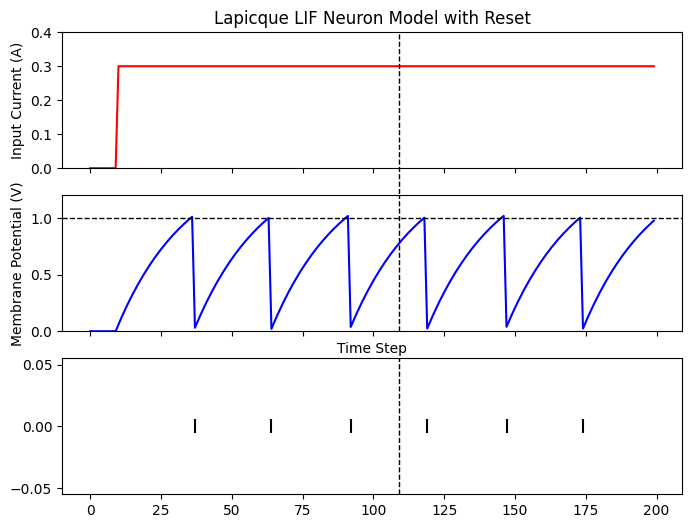

In [15]:
# Small step current input
curr_in = torch.zeros(200, 1)
curr_in[10:] = 0.3 # Step current input

# Initialize the membrane potential
Umem = torch.zeros(1)  # Initial membrane potential at t=0 is
Umem_rec = []  # To record the membrane potential at each time step
spk_rec = []

# neuron simulation
for step in range(len(curr_in)):
    Umem, spk = leaky_intergrate_and_fire(Umem, time_step=1e-3, I=curr_in[step])
    
    # store the membrane potential at each time step
    Umem_rec.append(Umem)
    spk_rec.append(spk)

# Convert the list of tensors to one tensor
Umem_rec = torch.stack(Umem_rec)
spk_rec = torch.stack(spk_rec)

# Plot the membrane potential and spikes over time
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in)), curr_in.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_ylim((0,0.4))
axs[0].set_title('Lapicque LIF Neuron Model with Reset')
axs[1].plot(np.arange(len(Umem_rec)), Umem_rec.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_xlabel('Time Step')
axs[1].set_ylim((0,1.2))

splt.raster(spk_rec, ax=axs[2], s=100, c="black", marker="|")

axs[0].axvline(x=109, ymin=-1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[1].axvline(x=109, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)
axs[2].axvline(x=109, ymax=1, color='k', linestyle='--', linewidth=1, clip_on=False)

axs[1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, label='Threshold')

As expected, membrane potential rises quickly, and since the membrane potential is reset to zero after each spike, the neuron fires more frequently.
Similarly, the same happens if we decrease the threshold. This requires creating a new neuron with a lower threshold, but the rest of the code remains the same. This time, we are going to use the `Lapicque` class from `snnTorch` with a lower threshold.

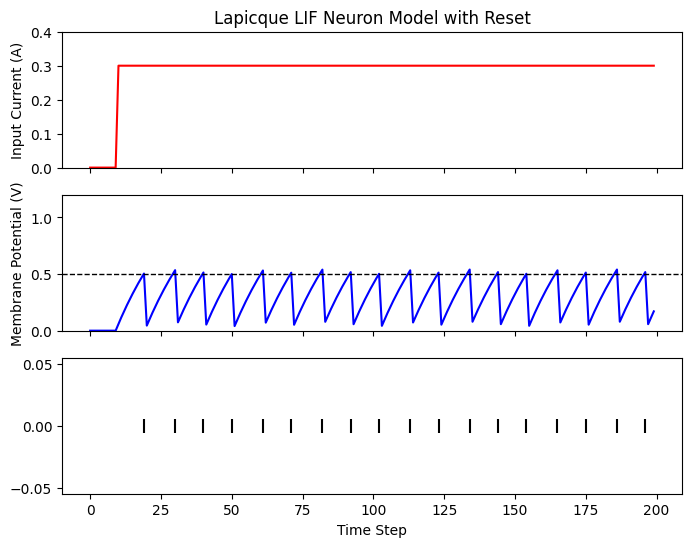

In [16]:
# LIF
threshold = 0.5
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=time_step, threshold=threshold)

# Small step current input
curr_in = torch.zeros(200, 1)
curr_in[10:] = 0.3 # Step current input

# Initialize the membrane potential
Umem = torch.zeros(1)  # Initial membrane potential at t=0 is
Umem_rec = []  # To record the membrane potential at each time step
spk_rec = []

# neuron simulation
for step in range(len(curr_in)):
    spk, Umem = lif2(curr_in[step], Umem)
    
    # store the membrane potential at each time step
    Umem_rec.append(Umem)
    spk_rec.append(spk)

# Convert the list of tensors to one tensor
Umem_rec = torch.stack(Umem_rec)
spk_rec = torch.stack(spk_rec)

# Plot the membrane potential and spikes over time
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axs[0].plot(np.arange(len(curr_in)), curr_in.numpy(), color='r')
axs[0].set_ylabel('Input Current (A)')
axs[0].set_ylim((0,0.4))
axs[0].set_title('Lapicque LIF Neuron Model with Reset')
axs[1].plot(np.arange(len(Umem_rec)), Umem_rec.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')
axs[1].set_ylim((0,1.2))
axs[2].set_xlabel('Time Step')

splt.raster(spk_rec, ax=axs[2], s=100, c="black", marker="|")

axs[1].axhline(y=threshold, color='k', linestyle='--', linewidth=1, label='Threshold')

And as expected, the neuron fires more frequently, since the threshold is lower.

That's what happens for a constant current injection. But in both deep neural networks and in the biological brain, most neurons will be connected to other neurons. They are more likely to receive spikes, rather than injections of constant current. So let's see how the neuron behaves when it receives spikes from other neurons.

## 3.5 LAPICQUE: SPIKE INPUT
In turorial 1, we use `snntorch.spikegen` module to create some randomly generated input spikes. Let's use that again, and see how the neuron responds to spikes.

In [17]:
# Create a 1-D ranom spike train. Each elemt has a probability of 40% of firing
spk_in = spikegen.rate_conv(torch.ones((num_steps, 1))*0.4)

# Lets see how many spikes we get, and what the spike probability is
num_spks = torch.sum(spk_in)
spk_prob = num_spks / num_steps
print(f"Number of spikes: {num_spks.item()}")
print(f"Spike probability: {spk_prob.item()}")

Number of spikes: 71.0
Spike probability: 0.35499998927116394


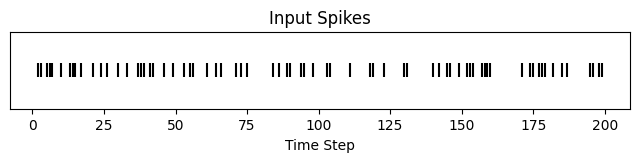

In [18]:
fig = plt.figure(facecolor='white', figsize=(8, 1))
axs = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps,-1), ax=axs, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time Step")
plt.yticks([])
plt.show()

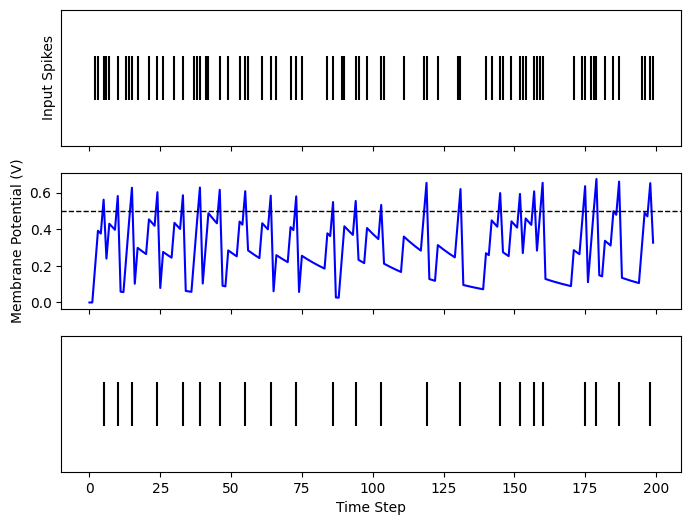

In [38]:
# Initialize the membrane potential
Umem = torch.zeros(1)  # Initial membrane potential at t=0 is
Umem_rec = []  # To record the membrane potential at each time step
spk_rec = []

# neuron simulation of random spike train
for step in range(len(spk_in)):
    spk, Umem = lif2(spk_in[step], Umem)
    
    # store the membrane potential at each time step
    Umem_rec.append(Umem)
    spk_rec.append(spk)

# Convert the list of tensors to one tensor
Umem_rec = torch.stack(Umem_rec)
spk_rec = torch.stack(spk_rec)

# Plot the membrane potential and spikes over time
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

splt.raster(spk_in.reshape(num_steps,-1), ax=axs[0], s=1000, c="black", marker="|")
axs[0].set_ylabel("Input Spikes")
axs[0].set_yticks([])

axs[1].plot(np.arange(len(Umem_rec)), Umem_rec.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')

splt.raster(spk_rec, ax=axs[2], s=1000, c="black", marker="|")
axs[2].set_yticks([])
axs[2].set_xlabel('Time Step')
axs[1].axhline(y=threshold, color='k', linestyle='--', linewidth=1, label='Threshold')


## 3.6 LAPICQUE: RESET MECHANISMS

The reset mechanism promotes a reduction of spike generation, which supplements part of the theory on how beains are so power efficient. Biologically, this drop of membrane potential is known as *hyperpolarization*. Following hyperpolarization, it is momentarily more difficult to elicit another spike from the neuron. Here, we use a reset mechanism to model hyperpolarization. 

There are two ways to implement the reset mechanism:
1. **Reset by subtraction** (default) - subtract the **threshold** from the membrane potential each time a spike is generated. 
2. **Reset to zero** - force the membrane potential to zero each time a spike is generated.
   
ofcourse it is also possible to remove the reset mechanism altogether, which leads to uncontrolled spike generation.

Lets instantiate another neuron model to demonstarte how to aternate between reset mechanisms. By default, snnTorch neuron models use `reset_mechanism="subtract"`. This can be explicitly overridden by passing the argument `reset_mechanism="zero"`.

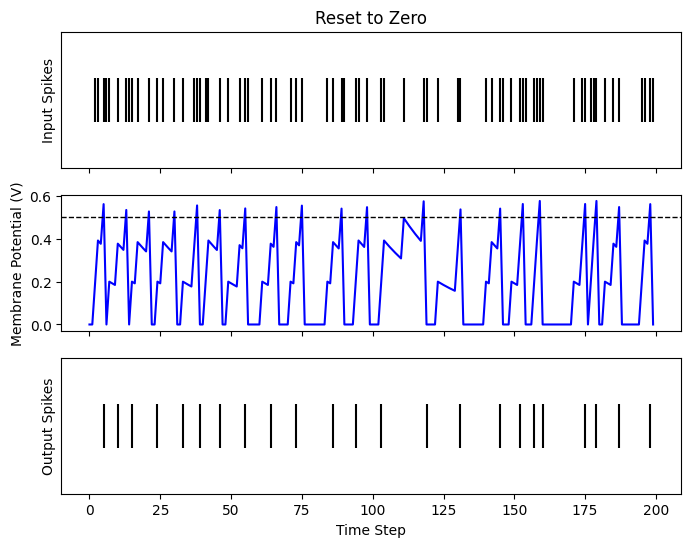

In [39]:
# Neuron with reset_mechanism set to "zero"
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=time_step, threshold=threshold, reset_mechanism="zero")

# Initialize inputs and outputs
Umem0 = torch.zeros(1)  # Initial membrane potential at t=0 is
Umem_rec0 = []  # To record the membrane potential at each time step
spk_rec0 = []

# neuron simulation of random spike train
for step in range(len(spk_in)):
    spk0, Umem0 = lif3(spk_in[step], Umem0)
    
    # store the membrane potential at each time step
    Umem_rec0.append(Umem0)
    spk_rec0.append(spk0)

# Convert the list of tensors to one tensor
Umem_rec0 = torch.stack(Umem_rec0)
spk_rec0 = torch.stack(spk_rec0)

# Plot the membrane potential and spikes over time
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

splt.raster(spk_in.reshape(num_steps,-1), ax=axs[0], s=1000, c="black", marker="|")
axs[0].set_ylabel("Input Spikes")
axs[0].set_yticks([])
axs[0].set_title("Reset to Zero")


axs[1].plot(np.arange(len(Umem_rec0)), Umem_rec0.numpy(), color='b')
axs[1].set_ylabel('Membrane Potential (V)')

splt.raster(spk_rec, ax=axs[2], s=1000, c="black", marker="|")
axs[2].set_yticks([])
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Output Spikes')
axs[1].axhline(y=threshold, color='k', linestyle='--', linewidth=1, label='Threshold')

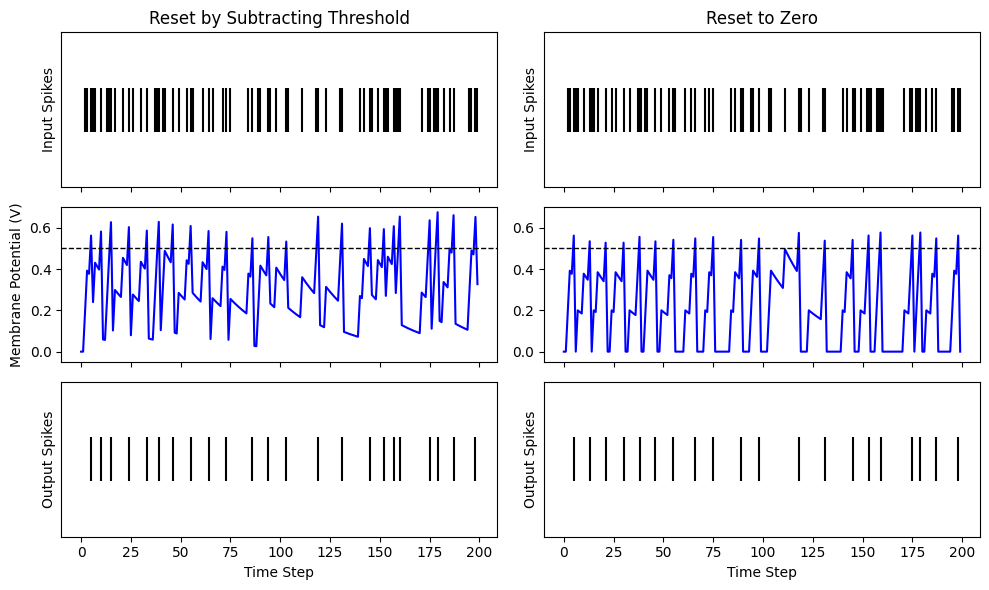

In [57]:
# plot the two models side by side
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
splt.raster(spk_in.reshape(num_steps,-1), ax=axs[0, 0], s=1000, c="black", marker="|")
axs[0, 0].set_ylabel("Input Spikes")
axs[0, 0].set_yticks([])
axs[0, 0].set_title("Reset by Subtracting Threshold") 

splt.raster(spk_in.reshape(num_steps,-1), ax=axs[0, 1], s=1000, c="black", marker="|")
axs[0, 1].set_ylabel("Input Spikes")
axs[0, 1].set_yticks([])
axs[0, 1].set_title("Reset to Zero") 

axs[1, 0].plot(np.arange(len(Umem_rec)), Umem_rec.numpy(), color='b')
axs[1, 0].set_ylabel('Membrane Potential (V)')
axs[1, 0].set_ybound((-0.05, 0.7))
axs[1, 0].axhline(y=threshold, color='k', linestyle='--', linewidth=1, label='Threshold')

axs[1, 1].plot(np.arange(len(Umem_rec0)), Umem_rec0.numpy(), color='b')
axs[1, 1].set_ybound((-0.05, 0.7))
axs[1, 1].axhline(y=threshold, color='k', linestyle='--', linewidth=1, label='Threshold')

splt.raster(spk_rec, ax=axs[2, 0], s=1000, c="black", marker="|")
axs[2, 0].set_yticks([])
axs[2, 0].set_xlabel('Time Step')
axs[2, 0].set_ylabel('Output Spikes')

splt.raster(spk_rec0, ax=axs[2, 1], s=1000, c="black", marker="|")
axs[2, 1].set_yticks([])
axs[2, 1].set_xlabel('Time Step')
axs[2, 1].set_ylabel('Output Spikes')

plt.tight_layout()
plt.show()



### Which reset mechanism is better?
Applying `subtract` ( the default value in `reset_mechanism`) is **less lossy**, because it doe not ignore how much the membrane exceeds the threshold by.

On the other hand, applying a hard reset with `zero` promotes **sparsity** and potentially less power consumption when running on dedicated neuromorphic hardware.

## CONCLUSION
In practice, we probably wouldn't use this neurom model to train a neural network. The Lapicque model has added a lot of hyperparameters tp tune: $R, C, \Delta t, U_{thres}$, and the choice of reset mechanism. It's a little daunting to set all these parameters, so in the next tutorial we will intoroduce a neuron model that is beeter suited for large scale deep learning.